
## Lab 6 - part 1:  Networks

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>


## Table of Contents

* [Learning Goals](#chapter0)
* [Street Networks](#chapter1)
    * [Overview demonstration of OSMnx](#section1_1)
    * [Get shapefiles from OpenStreetMap](#section1_2)
    * [Download and construct street networks](#section1_3)
        * [Method 1: Pass a bounding box](#section1_3_1)
        * [Method 2: Pass a lat-long point and bounding box distance in meters](#section1_3_2)
        * [Method 3: Pass a (lat,lon) point and network distance in meters ](#section1_3_3)
        * [Method 4: Pass an address and distance (bounding box or network) in meters](#section1_3_4)
        * [Method 5: Pass a place name](#section1_3_5)
    * [Simlifying street network topography](#section1_4)
    * [Saving networks to disk](#section1_5)
    * [Calculate basic network metrics](#section1_6)
* [Use OSMnx to create and analyze a NetworkX street network](#chapter2)
    * [Calculate basic (and more advanced) street network metrics](#section2_1)
    * [Inside a Networkx graph](#section2_2)

    

## Learning Goals <a class="anchor" id="chapter0"></a>

1. Understand how to use OSMnx and create visualisations of street networks using it. 
1. Develop an understanding of the different methods that can be used to construct networks.
1. Understand the concept of spatial weights & spatial lag and use the same to create a Moran plot.


## Street Networks <a class="anchor" id="chapter1"></a>

### Overview demonstration of OSMnx <a class="anchor" id="section1_1"></a>

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API. More about OSMnx from the creator Geoff Boeing directly: https://github.com/gboeing/osmnx

It is already within the installation file or the docker image that you used at the beginning of the course. If you are following a third way, you can install it as follows.

Install OSMnx: `conda install -c conda-forge osmnx`

Note: If you wish to revisit the section on APIs, you can find it in Lab 1.

In [1]:
import osmnx as ox, geopandas as gpd
import pandas as pd
import matplotlib
%matplotlib inline
ox.settings.log_console=True
ox.settings.use_cache=True

### Get shapefiles from OpenStreetMap <a class="anchor" id="section1_2"></a>

OSMnx lets you download spatial "place boundary" geometries from OpenStreetMap, save them to shapefiles, project them, and plot them. For a more in-depth demonstration of creating these shapefiles, see [OSMnx examples](https://github.com/gboeing/osmnx).

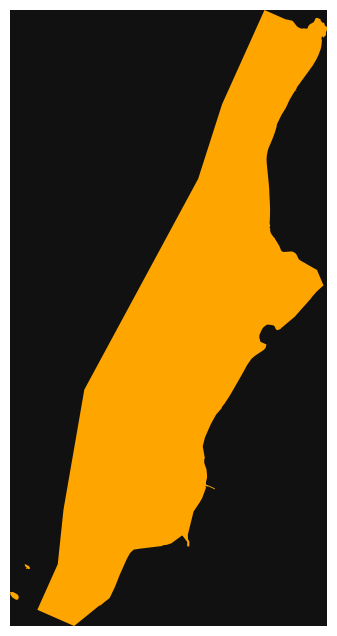

In [2]:
gdf = ox.geocode_to_gdf('Manhattan, New York, NY, USA')
#gdf = gdf.append(_geocode_query_to_gdf('Manhattan, New York, NY, USA'))
area = ox.project_gdf(gdf)
fig, ax = ox.plot_footprints(area)

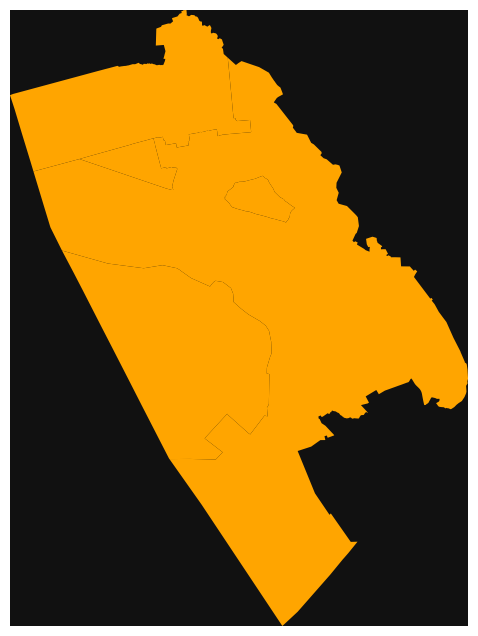

In [3]:
# get the boundary polygons for multiple cities, save as shapefile, project to UTM, and plot
place_names = ['Berkeley, California, USA', 
               'Oakland, California, USA',
               'Piedmont, California, USA',
               'Emeryville, California, USA',
               'Alameda, Alameda County, CA, USA']
east_bay = ox.geocode_to_gdf(place_names)
#ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_footprints(east_bay)

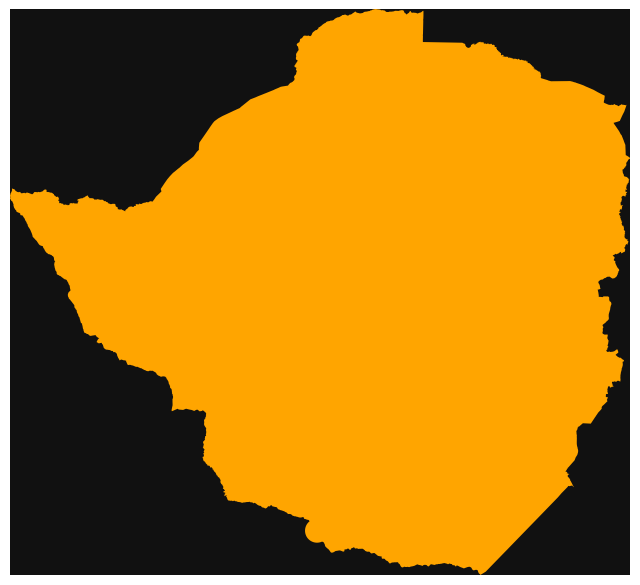

In [4]:
# or get shapes of boroughs, counties, states, countries - anything OpenStreetMap has boundary geometry for
country = ox.geocode_to_gdf('Zimbabwe')
country = ox.project_gdf(country)
fig, ax = ox.plot_footprints(country)

### Download and construct street networks <a class="anchor" id="section1_3"></a>

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [OSMnx examples](https://github.com/gboeing/osmnx).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method 1: Pass a bounding box<a class="anchor" id="section1_3_1"></a>
 This constructs the network from all the OSM nodes and ways within the bounding box.

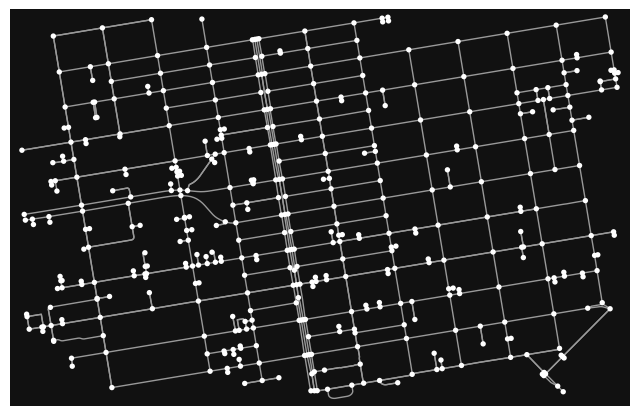

In [5]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

#### Method 2: Pass a lat-long point and bounding box distance in meters <a class="anchor" id="section1_3_2"></a>
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

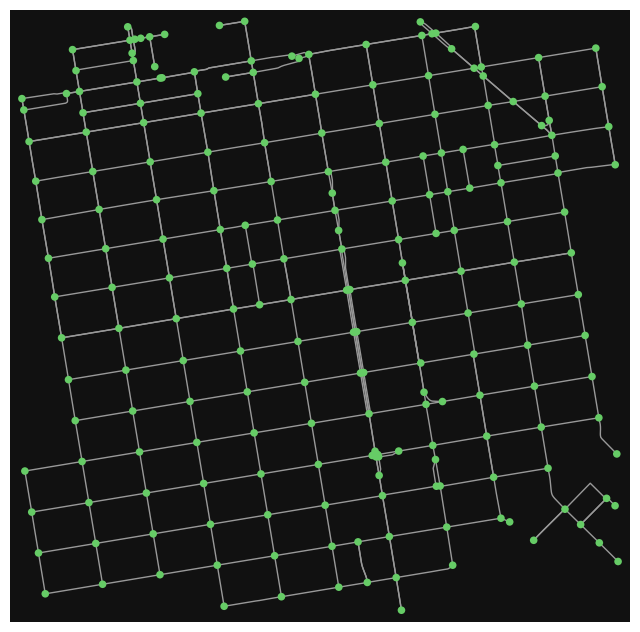

In [6]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

#### Method 3: Pass a (lat,lon) point and *network* distance in meters <a class="anchor" id="section1_3_3"></a>

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

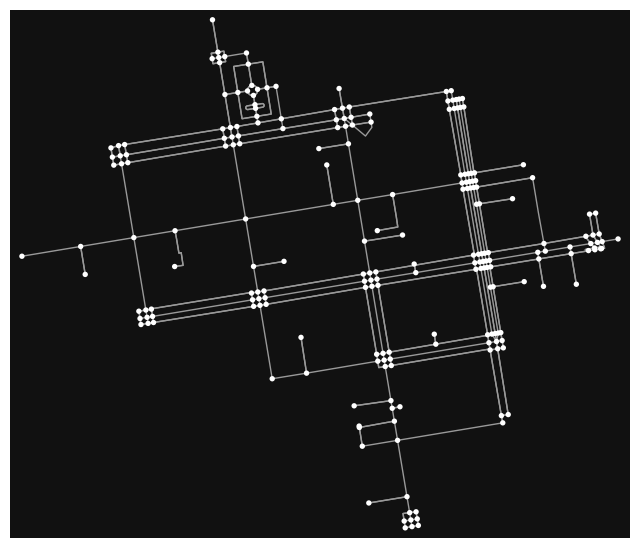

In [7]:
# same point again, but create network only of nodes within 500m along the network from point
G3 = ox.graph_from_point(location_point, dist=500, dist_type='network')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

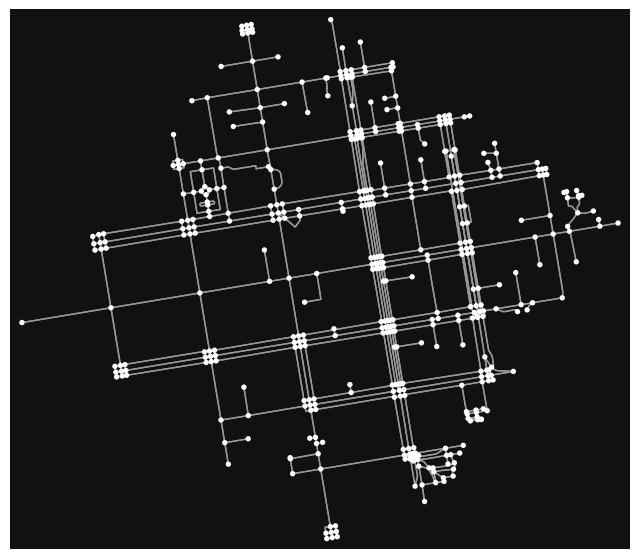

In [8]:
# create network only of nodes within 500m walking along the network from point
G3 = ox.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

#### Method 4: Pass an address and distance (*bounding box* or *network*) in meters <a class="anchor" id="section1_3_4"></a>
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if distance_type='network').

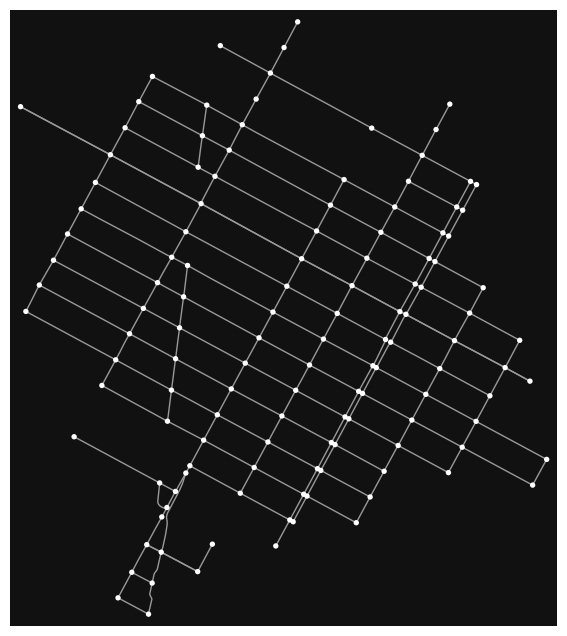

In [9]:
# network from address, including only nodes within 1km along the network from the address
G4 = ox.graph_from_address(address='350 5th Ave, New York, NY', 
                              dist=1000, dist_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

#### Method 5: Pass a place name <a class="anchor" id="section1_3_5"></a>

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then prunes all nodes that lie outside the place's boundary polygon.

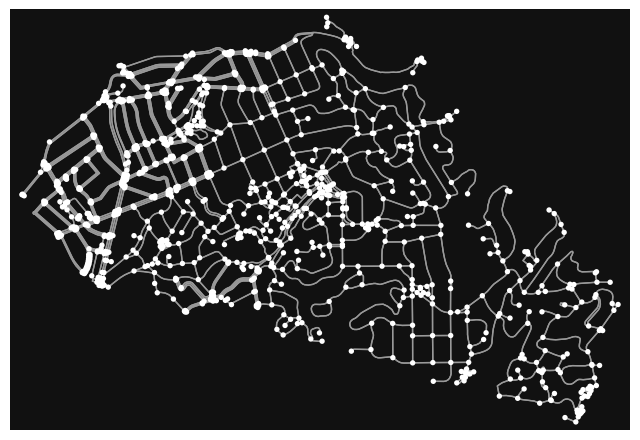

In [10]:
# create the street network within the city of Piedmont's borders
G5 = ox.graph_from_place('Piedmont, California, USA', network_type='walk')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

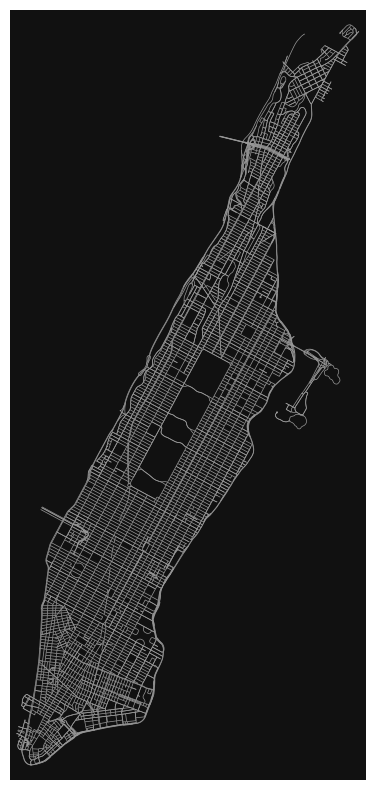

In [11]:
# create the street network within Manhattan
G5 = ox.graph_from_place('Manhattan, New York, NY, USA', network_type='drive')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, figsize=(10,10), node_size=0, edge_linewidth=0.5)

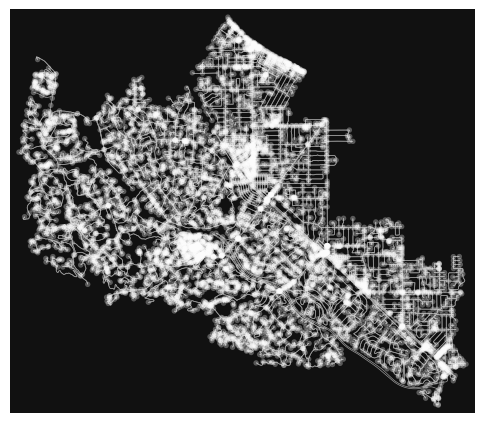

In [12]:
# you can also pass multiple places as a mixed list of strings and/or structured queries
places = ['Los Altos, California, USA',
          {'city':'Los Altos Hills', 'state':'California'},
          'Loyola, California']
G5 = ox.graph_from_place(places)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, figsize=(6,6), node_alpha=0.3, edge_linewidth=0.5)
ox.save_graph_geopackage(G5,'silicon-valley')

### Simplifying street network topology <a class="anchor" id="section1_4"></a>

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [13]:
# create a network around some (lat, lon) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, dist=500, simplify=False)

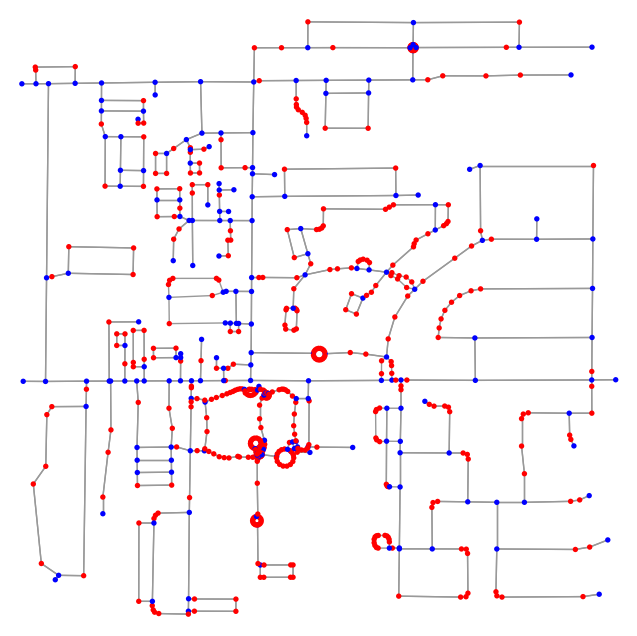

In [14]:
# turn off strict mode and see what nodes we'd remove, in red
nc = ['b' if ox.simplification._is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3, bgcolor='#FFFFFF')

The red and blue dots above are OSM nodes. We'll remove the nodes in red as they're not real network nodes.

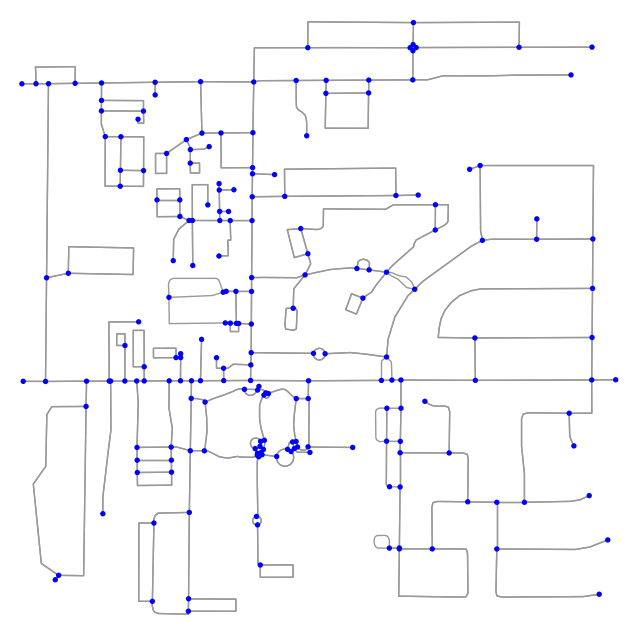

In [15]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3, bgcolor='#FFFFFF')

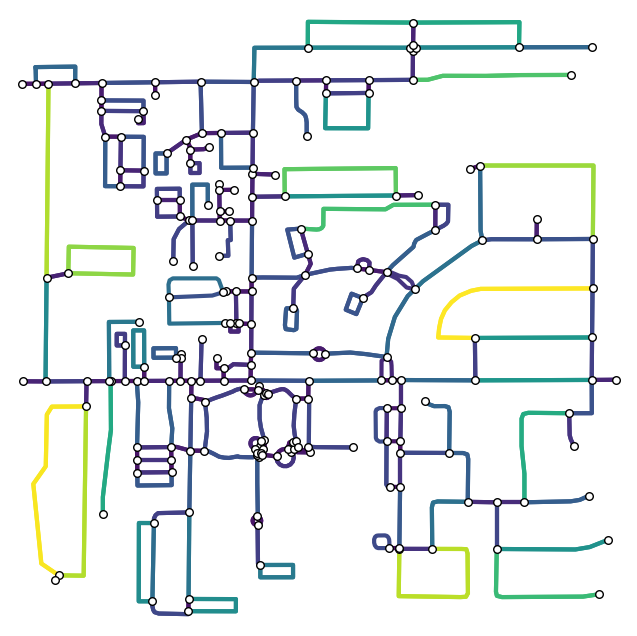

In [16]:
# show the simplified network with edges colored by edge length
ec = ox.plot.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3, bgcolor='#FFFFFF')

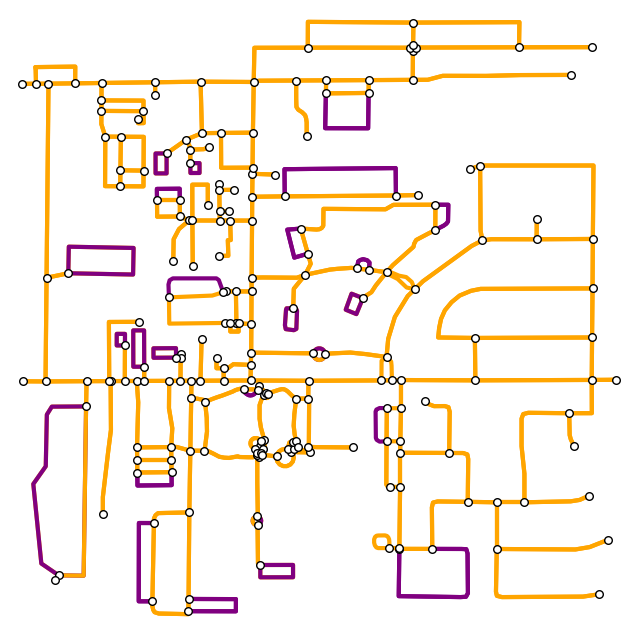

In [17]:
# highlight all parallel edges in purple
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3, bgcolor='#FFFFFF')

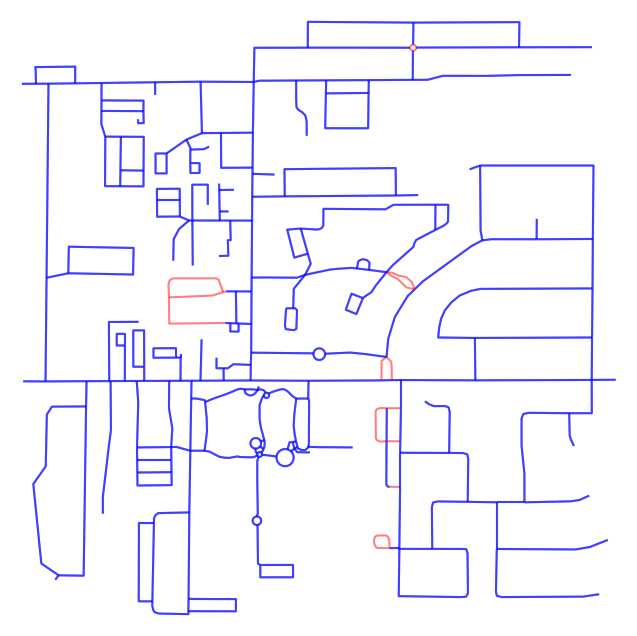

In [18]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5, bgcolor='#FFFFFF')

### Saving networks to disk <a class="anchor" id="section1_5"></a>

For more examples of saving and loading networks to/from disk, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [19]:
# save street network as ESRI shapefile to work with in GIS
ox.save_graph_geopackage(G, 'network-shape')

In [20]:
# save street network as GraphML file to work with in networkx or gephi
ox.save_graphml(G, 'network.graphml')

In [21]:
# save street network as SVG to work with in Adobe Illustrator
fig, ax = ox.plot_graph(G, show=False, save=True, close=True, filepath='./network.svg')

In [22]:
# get one of each network type and save to disk as image and shapefile
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('N Sicily Pl, Chandler, AZ', network_type=nt, dist=1500)
    filename = 'az-{}'.format(nt)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filepath=filename+'.png', show=False, close=True)

For examples of working with these street networks in networkx, see [OSMnx examples](https://github.com/gboeing/osmnx).

### Calculate basic network metrics <a class="anchor" id="section1_6"></a>

In [23]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats['circuity_avg']

1.0818206754559168

## Use OSMnx to create and analyze a NetworkX street network <a class="anchor" id="chapter2"></a>


### Calculate basic (and more advanced) street network metrics <a class="anchor" id="section2_1"></a>

In [24]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA', network_type='drive_service'))

In [25]:
stats

{'n': 465,
 'm': 1174,
 'k_avg': 5.049462365591398,
 'edge_length_total': 119896.82899999994,
 'edge_length_avg': 102.12677086882448,
 'streets_per_node_avg': 2.739784946236559,
 'streets_per_node_counts': {0: 0, 1: 88, 2: 2, 3: 321, 4: 52, 5: 1, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.18924731182795698,
  2: 0.004301075268817204,
  3: 0.6903225806451613,
  4: 0.11182795698924732,
  5: 0.002150537634408602,
  6: 0.002150537634408602},
 'intersection_count': 377,
 'street_length_total': 62023.56299999996,
 'street_segment_count': 611,
 'street_length_avg': 101.51155973813414,
 'circuity_avg': 1.1086330379166485,
 'self_loop_proportion': 0.004909983633387889}

In [26]:
stats['circuity_avg']

1.1086330379166485

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise `basic_stats()` will just skip them in the calculation):

In [27]:
# get the street network for a place, and its area in square meters (by projecting)
place = 'Piedmont, California, USA'
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [28]:
# calculate basic and display
stats = ox.basic_stats(G, area=area)
pd.Series(stats)

n                                                                             465
m                                                                            1174
k_avg                                                                    5.049462
edge_length_total                                                      119896.829
edge_length_avg                                                        102.126771
streets_per_node_avg                                                     2.739785
streets_per_node_counts            {0: 0, 1: 88, 2: 2, 3: 321, 4: 52, 5: 1, 6: 1}
streets_per_node_proportions    {0: 0.0, 1: 0.18924731182795698, 2: 0.00430107...
intersection_count                                                            377
street_length_total                                                     62023.563
street_segment_count                                                          611
street_length_avg                                                       101.51156
circuity_avg    

Notice that this returns the basic stats as a dict, which we threw into a pandas series. Degree counts and proportions are nested dicts inside it. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [29]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportions'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportions']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

n       m     k_avg  edge_length_total  edge_length_avg  \
0  465.0  1174.0  5.049462         119896.829       102.126771   

   streets_per_node_avg  intersection_count  street_length_total  \
0              2.739785               377.0            62023.563   

   street_segment_count  street_length_avg  ...  int_4_count  int_5_count  \
0                 611.0          101.51156  ...         52.0          1.0   

   int_6_count  int_0_prop  int_1_prop  int_2_prop  int_3_prop  int_4_prop  \
0          1.0         0.0    0.189247    0.004301    0.690323    0.111828   

   int_5_prop  int_6_prop  
0    0.002151    0.002151  

[1 rows x 30 columns]

In [30]:
# proportion of intersections that are cul-de-sacs, T-intersections, and X-intersections?
print(stats['int_1_prop'])
print(stats['int_3_prop'])
print(stats['int_4_prop'])

0.18924731182795698
0.6903225806451613
0.11182795698924732


In [31]:
# how many streets emanate from each intersection?
ox.stats.streets_per_node_counts(G)

{0: 0, 1: 88, 2: 2, 3: 321, 4: 52, 5: 1, 6: 1}

### Inside a NetworkX graph <a class="anchor" id="section2_2"></a>

In [32]:
# nodes
list(G.nodes(data=True))[0:2]

[(53017091, {'y': 37.8262501, 'x': -122.2476037, 'street_count': 3}),
 (53018397, {'y': 37.8242243, 'x': -122.247194, 'street_count': 3})]

In [33]:
# edges
list(G.edges(keys=True, data=True))[0:2]

[(53017091,
  53064327,
  0,
  {'osmid': 6345781,
   'name': 'Rose Avenue',
   'highway': 'residential',
   'oneway': False,
   'reversed': False,
   'length': 230.124,
   'geometry': <LINESTRING (-122.248 37.826, -122.248 37.826, -122.246 37.828)>}),
 (53017091,
  53075599,
  0,
  {'osmid': 6345781,
   'name': 'Rose Avenue',
   'highway': 'residential',
   'oneway': False,
   'reversed': True,
   'length': 122.23500000000001,
   'geometry': <LINESTRING (-122.248 37.826, -122.248 37.826, -122.248 37.826, -122.248 37....>})]

In [34]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.nearest_nodes(G, 37.792896, -122.412325)
destination_node = ox.nearest_nodes(G, 37.790495, -122.408353)
origin_node, destination_node

(53035698, 53035698)

In [35]:
# find the shortest path between origin and destination nodes
import networkx as nx
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[53035698]'

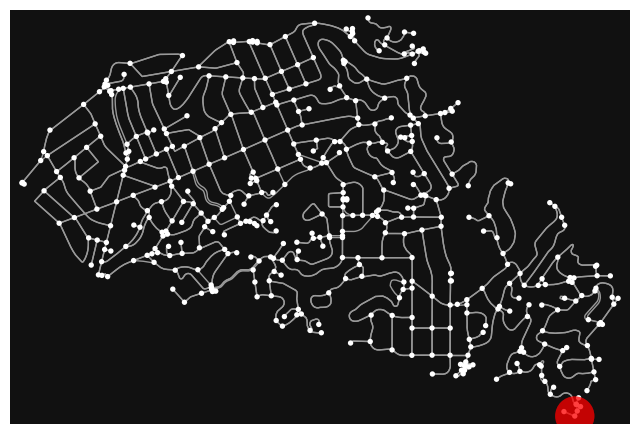

In [36]:
# plot the route showing origin/destination lat-long points in big size
fig, ax = ox.plot_graph_route(G, route, orig_dest_size=800)